# 초간단 LoRA 실험

- LoRA 작동 원리를 확인하기 위해 MNIST 데이터 셋에 대해서 다음과 같은 절차를 적용

- 1. Linear 레이어만으로 구성된 모델을 MNIST 데이터셋에서 홀수 데이터 샘플만 추출해서 학습시킨다. 이 모델을 `model_odd`라 한다.

- 2. 홀수 데이터 셋에 `model_odd` 성능을 검증하고, 전체 데이터 셋에서 모델 성능을 검증한다.

- 3. LoRA 어댑터를 적용한 `model_lora`를 정의하고 `model_odd`의 학습된 파라미터를 `model_lora`에 입력한다.

- 4. `model_odd`로 부터 받은 파라미터를 고정하고 추가한 LoRA 어댑터에 있는 파라미터만 학습 가능하게 만든다.

- 5. 전체 데이터 셋에 대해서 처음부터 다시 학습힌다.

- 6. 전체 데이터 셋에 대해서 `model_lora` 성능을 검증한다.

- 7. 2, 5에서 학습된 `model_odd`의 파리미터와 `model_lora`에서 추가 학습된 파라미터를 병합하여 재사용하는 방법을 테스트 한다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

- 하이퍼 파라미터 설정

In [2]:
# 하이퍼파라미터 설정
batch_size = 64
learning_rate = 0.001
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# MNIST 데이터셋 로드 및 전처리
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 1048460.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160252.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1515893.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3860289.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Model Odd

- 홀수 데이터만 필터링

In [4]:

# 홀수 데이터(1, 3, 5, 7, 9)만 선택
odd_classes = [1, 3, 5, 7, 9]

def filter_odd_indices(dataset):
    indices = [i for i, (_, label) in enumerate(dataset) if label in odd_classes]
    return indices

train_indices = filter_odd_indices(train_dataset)
test_indices = filter_odd_indices(test_dataset)

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
train_loader_iter = iter(train_loader)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


- 필터링 된 데이터 확인

In [5]:
mini_batch = next(train_loader_iter)
X, y = mini_batch[0], mini_batch[1]

X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [6]:
y

tensor([3, 7, 3, 1, 5, 7, 7, 9, 5, 7, 1, 1, 3, 1, 1, 1, 7, 1, 5, 7, 3, 5, 5, 1,
        7, 9, 1, 9, 1, 1, 3, 9, 9, 7, 9, 3, 1, 7, 3, 1, 3, 5, 5, 3, 5, 5, 9, 9,
        1, 7, 5, 7, 7, 1, 3, 1, 9, 3, 7, 3, 7, 7, 1, 3])

tensor(3)


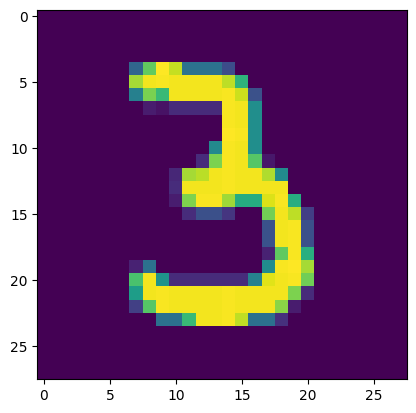

In [7]:
plt.imshow(X[0].permute(1,2,0))
print(y[0])
plt.show()

In [8]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # 출력 노드를 10개로 설정

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_odd = MLP()

In [9]:
# forward test
X = torch.rand(2, 1, 28, 28)
y = model_odd(X)
y.shape

torch.Size([2, 10])

In [10]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_odd.parameters(), lr=learning_rate)

In [11]:
# 학습 함수 정의
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')


# 테스트 함수 정의
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # 배치 손실을 더함
            pred = output.argmax(dim=1, keepdim=True)  # 가장 높은 확률을 가진 클래스를 예측
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    return accuracy



In [12]:
model_odd.to(device)

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
# 학습 및 평가
for epoch in range(1, num_epochs + 1):
    train(model_odd, device, train_loader, optimizer, epoch)
    accuracy = test(model_odd, device, test_loader)
    print("----------------------------------------------------\n")

Train Epoch: 1 [0/30508 (0%)]	Loss: 2.316929
Train Epoch: 1 [6400/30508 (21%)]	Loss: 0.104933
Train Epoch: 1 [12800/30508 (42%)]	Loss: 0.056871
Train Epoch: 1 [19200/30508 (63%)]	Loss: 0.154260
Train Epoch: 1 [25600/30508 (84%)]	Loss: 0.264731

Test set: Average loss: 0.0014, Accuracy: 4936/5074 (97.28%)

----------------------------------------------------

Train Epoch: 2 [0/30508 (0%)]	Loss: 0.023683
Train Epoch: 2 [6400/30508 (21%)]	Loss: 0.044749
Train Epoch: 2 [12800/30508 (42%)]	Loss: 0.077015
Train Epoch: 2 [19200/30508 (63%)]	Loss: 0.055855
Train Epoch: 2 [25600/30508 (84%)]	Loss: 0.029487

Test set: Average loss: 0.0010, Accuracy: 4975/5074 (98.05%)

----------------------------------------------------

Train Epoch: 3 [0/30508 (0%)]	Loss: 0.102613
Train Epoch: 3 [6400/30508 (21%)]	Loss: 0.014800
Train Epoch: 3 [12800/30508 (42%)]	Loss: 0.027800
Train Epoch: 3 [19200/30508 (63%)]	Loss: 0.028533
Train Epoch: 3 [25600/30508 (84%)]	Loss: 0.067982

Test set: Average loss: 0.0008, A

In [14]:
# 학습 완료 후 모델 저장
torch.save(model_odd.state_dict(), "model_odd.pth")

- 모든 숫자를 포함하고 있는 데이터에 대해서 성능 검증

In [15]:
# 모든 데이터가 다 들어 있는 데이터 로더를 다시 만듬
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_iter = iter(train_loader)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model LoRA



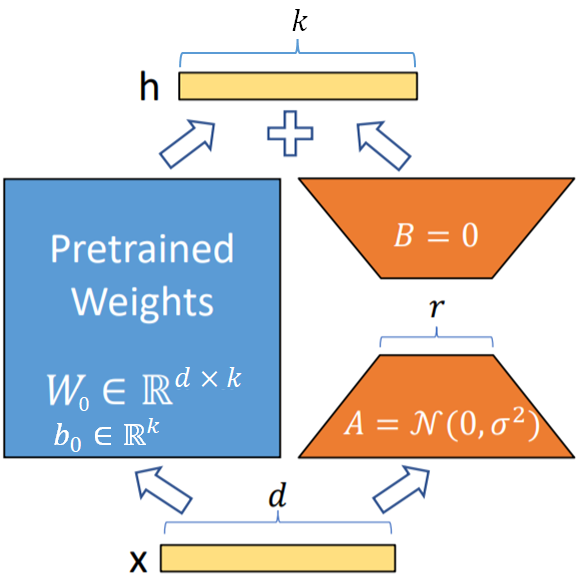

- 기존에 학습되어 고정된 Linear 레이어의 파라미터가 $W_0$라고 할때 이 레이어의 계산은 $h = W_0 x + b_0$

- 여기에 두 Linear 레이어 A, B를 추가 하는데 Linear A는 (d,r), Linear B는 (r, k) 이며 $r \ll min(d, k)$ 로 정의

- 이 상태에서 입력 $x$를 기존 Linear 레이어, 새롭게 추가된 Linear 레이어에 통과 시키고 결과를 덧셈

-  $h = W_0 x + b_0$라는 Linear 레이어의 계산이 $h = (W_0 x + b_0)+ s B A x = W_0 x + s \Delta W x + b_0 = (W_0 + s \Delta W)x + b_0$ 로 변환

- $s = \alpha / r$인 스케일 팩터로 하이퍼파라미터 $\alpha$가 커지면 $BA$의 영향력이 커짐

- 예를 들어 $d=768$, $k=256$이면 $W_0$는 파라미터 196608개를 가지지만 새로 정의된 A, B는 $r=4$일 경우

- $(767\times4)+(4\times256)=4092$로 파라미터 4092개만 가짐

- 이 새롭게 추가된 4092개만 학습 시켜도 괜찮은 미세조정 결과를 얻을 수 있다는 것이 LoRA의 핵심 내용



In [16]:
# LoRA Adapter 정의
class LoRA(nn.Module):
    def __init__(self, in_features, out_features, r=4, alpha=None):
        super(LoRA, self).__init__()

        self.r = r

        if alpha is None:
            self.alpha = r
        else:
            self.alpha = alpha

        self.lora_A = nn.Linear(in_features, r, bias=False)
        self.lora_B = nn.Linear(r, out_features, bias=False)
        # B의 가중치를 0으로 초기화
        nn.init.zeros_(self.lora_B.weight)

        self.scale = self.alpha / r  # 스케일링 파라미터

    def forward(self, x):
        return self.lora_B(self.lora_A(x)) * self.scale

In [17]:
# 기존 MLP 모델에 LoRA Adapter 추가
class MLPWithLoRA(nn.Module):
    def __init__(self, lora_config):
        super().__init__()
        self.lora_config = lora_config
        r = lora_config['r']
        lora_alpha = lora_config['lora_alpha']

        self.fc1 = nn.Linear(28*28, 256)
        self.fc1_lora = LoRA(28*28, 256, r=r, alpha=lora_alpha)

        self.fc2 = nn.Linear(256, 128)
        self.fc2_lora = LoRA(256, 128, r=r, alpha=lora_alpha)

        self.fc3 = nn.Linear(128, 10)  # 전체 클래스(0~9)를 학습

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x) + self.fc1_lora(x))  # 기존 레이어와 LoRA를 더함
        x = torch.relu(self.fc2(x) + self.fc2_lora(x))
        x = self.fc3(x)

        return x

    # LoRA에 관련된 파라미터만 저장하는 함수
    def save_trainable_parameters(self, file_path):
        # requires_grad=True인 파라미터만 선택하여 저장
        trainable_state_dict = {
            name: param for name, param in self.named_parameters()
                if param.requires_grad
        }
        # LoRA config 추가 저장
        trainable_state_dict['alpha'] = self.lora_config['lora_alpha']
        trainable_state_dict['r'] = self.lora_config['r']

        torch.save(trainable_state_dict, file_path)

In [18]:
# model_lora 초기화
model_lora = MLPWithLoRA(
    # lora_config
    dict(r=4, lora_alpha=8)
)
model_lora.to(device)

MLPWithLoRA(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc1_lora): LoRA(
    (lora_A): Linear(in_features=784, out_features=4, bias=False)
    (lora_B): Linear(in_features=4, out_features=256, bias=False)
  )
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc2_lora): LoRA(
    (lora_A): Linear(in_features=256, out_features=4, bias=False)
    (lora_B): Linear(in_features=4, out_features=128, bias=False)
  )
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [19]:
# model_odd의 파라미터 로드
odd_state_dict = torch.load("model_odd.pth", weights_only=True)
model_lora.fc1.weight.data = odd_state_dict['fc1.weight']
model_lora.fc1.bias.data = odd_state_dict['fc1.bias']
model_lora.fc2.weight.data = odd_state_dict['fc2.weight']
model_lora.fc2.bias.data = odd_state_dict['fc2.bias']
model_lora.fc3.weight.data = odd_state_dict['fc3.weight']
model_lora.fc3.bias.data = odd_state_dict['fc3.bias']

# 기존 모델의 파라미터를 고정
for param in model_lora.fc1.parameters():
    param.requires_grad = False
for param in model_lora.fc2.parameters():
    param.requires_grad = False
for param in model_lora.fc3.parameters():
    param.requires_grad = False

# 로라 어댑터 부분만 학습 가능하도록 설정
for param in model_lora.fc1_lora.parameters():
    param.requires_grad = True
for param in model_lora.fc2_lora.parameters():
    param.requires_grad = True

In [20]:
# forward test
X = torch.rand(2, 1, 28, 28).cuda()
y = model_lora(X)

- 학습 가능 파라미터 수를 확인

- 전체 파라미터의 2.37%만 학습 시켜서 짝수 레이블에 대해서도 잘 예측하는 모델을 학습

In [21]:
def count_parameters(model):
    # tensor.numel() 설명
    # foo = torch.tensor([[1,2,3], [4,5,6]])
    # foo.numel()
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# 전체 파라미터 개수와 학습 가능한 파라미터 개수를 계산
total_params, trainable_params = count_parameters(model_lora)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Ratio of trainable parameters: {(trainable_params/total_params)*100:.3}%")

Total parameters: 240842
Trainable parameters: 5696
Ratio of trainable parameters: 2.37%


- `filter()`함수를 써서 `requires_grad=True`인 파라미터만 옵티마이저에 전달

In [22]:
# 짝수만 필터링하는 예제
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
even_numbers = filter(lambda x: x % 2 == 0, numbers)
print(list(even_numbers))  # [2, 4, 6, 8, 10]

# 모델의 전체 파라미터 덩어리 수와 필터링한 파라미터 덩어리수
print(
    len(list(model_lora.parameters())), # 전체 5개의 Linear에서 w, b가 있으므로 10개
    len(list(filter(lambda p: p.requires_grad, model_lora.parameters()))) # lora adapter 2개에서 A, B 있으므로 4개
)

[2, 4, 6, 8, 10]
10 4


In [23]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()

# model_lora.parameters()는 weight, bias가 모여있는 iterable이므로
# 이 요소들 중에 requires_grad=True인 것만 리스트로 모음
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_lora.parameters()),
    lr=learning_rate
)


In [24]:
# 학습
for epoch in range(1, num_epochs + 1):
    train(model_lora, device, train_loader, optimizer, epoch)
    accuracy = test(model_lora, device, test_loader)
    print("----------------------------------------------------\n")

Train Epoch: 1 [0/60000 (0%)]	Loss: 10.358255
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.390692
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.259073
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.894022
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.897856
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.672043
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.516898
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.444051
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.359290
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.406334

Test set: Average loss: 0.0057, Accuracy: 8989/10000 (89.89%)

----------------------------------------------------

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.170984
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.294351
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.110249
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.192842
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.233185
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.179776
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.349979
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.

In [25]:
# model_odd, model_lora 모델을 전체 데이터 셋에서 테스트
# 전자는 50%가 나오기를 기대, 후자는 95%이상 나오길 기대
test(model_odd, device, test_loader)
test(model_lora, device, test_loader);


Test set: Average loss: 0.1524, Accuracy: 5002/10000 (50.02%)


Test set: Average loss: 0.0017, Accuracy: 9678/10000 (96.78%)



In [26]:
# LoRA 파라미터 저장
model_lora.save_trainable_parameters("model_lora_trainable.pth")

## 새로운 모델에 병합

- 위 과정에서 홀수만 구분하는 베이스 모델과 추가 학습된 LoRA 파라미터만 저장

- 향후 모든 숫자를 잘 구분하는 모델을 다시 생성하고자 할때 이 둘을 로딩해서 병합하여 사용하여야 함

- LoRA가 적용되지 않은 기본 모델 다시 로딩

In [27]:
model_base = MLP()

odd_state_dict = torch.load("model_odd.pth", weights_only=True)
model_base.fc1.weight.data = odd_state_dict['fc1.weight']
model_base.fc1.bias.data = odd_state_dict['fc1.bias']

model_base.fc2.weight.data = odd_state_dict['fc2.weight']
model_base.fc2.bias.data = odd_state_dict['fc2.bias']

model_base.fc3.weight.data = odd_state_dict['fc3.weight']
model_base.fc3.bias.data = odd_state_dict['fc3.bias']

test(model_base, device, test_loader)


Test set: Average loss: 0.1524, Accuracy: 5002/10000 (50.02%)



50.02

- LoRA로 학습된 추가 파라미터 로딩

In [28]:
lora_state_dict = torch.load("model_lora_trainable.pth", weights_only=True)
for k in lora_state_dict.keys():
    if 'weight' in k :
        print(f"{k}: {lora_state_dict[k].shape}")
    else:
        print(f"{k}: {lora_state_dict[k]}")

fc1_lora.lora_A.weight: torch.Size([4, 784])
fc1_lora.lora_B.weight: torch.Size([256, 4])
fc2_lora.lora_A.weight: torch.Size([4, 256])
fc2_lora.lora_B.weight: torch.Size([128, 4])
alpha: 8
r: 4


- 두 파라미터를 다음 관계를 이용해서 병합

-  $h = W_0 x + b_0$라는 Linear 레이어의 계산이 $h = (W_0 x + b_0)+ s B A x = W_0 x + s\Delta W x + b_0 = (W_0 + s\Delta W)x + b_0$ 로 변환

In [29]:
def merge_lora_weights(model_base, lora_params):
    a = lora_params['alpha']
    r = lora_params['r']

    ############################################################################
    # fc1 레이어의 가중치 병합
    lora_A_fc1 = lora_params["fc1_lora.lora_A.weight"]  # A 행렬 (r x in_features)
    lora_B_fc1 = lora_params["fc1_lora.lora_B.weight"]  # B 행렬 (out_features x r)
    lora_weight_fc1 = (a/r)*torch.matmul(lora_B_fc1, lora_A_fc1)  # BA 계산 (out_features x in_features)

    # 원래 가중치에 BA 가중치를 더함
    print(model_base.fc1.weight.shape)
    model_base.fc1.weight.data += lora_weight_fc1

    ############################################################################
    # fc2 레이어의 가중치 병합
    lora_A_fc2 = lora_params["fc2_lora.lora_A.weight"]
    lora_B_fc2 = lora_params["fc2_lora.lora_B.weight"]
    lora_weight_fc2 = (a/r)*torch.matmul(lora_B_fc2, lora_A_fc2)

    # 원래 가중치에 BA 가중치를 더함
    print(model_base.fc2.weight.shape)
    model_base.fc2.weight.data += lora_weight_fc2

    ############################################################################
    # fc3 레이어는 LoRA가 적용되지 않았으므로 변경할 필요 없음

    return model_base


In [30]:
merged_model = merge_lora_weights(model_base, lora_state_dict)

torch.Size([256, 784])
torch.Size([128, 256])


- 병합된 모델의 정확도 테스트

In [31]:
test(merged_model, device, test_loader)


Test set: Average loss: 0.0017, Accuracy: 9678/10000 (96.78%)



96.78